<a href="https://colab.research.google.com/github/epdgit/dotfiles/blob/master/C%C3%B3pia_de_acidentes2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
path_acidentes = '/content/drive/My Drive/acidentes2018_todas_causas_tipos (1).csv'
df = pd.read_csv(path_acidentes, sep=';', na_values='-', decimal=',', engine='python', encoding='ISO-8859-1')  

In [ ]:
df.shape

(324809, 37)

In [ ]:
# Criando colunas com os tipos de acidentes:
df2 = df.drop_duplicates(subset=['tipo_acidente'])

for evento in df2['tipo_acidente'].values:
    df[evento] = 0 

# Atribuindo valor 1 para toda linha em que o tipo de acidente é registrado
m = []
for column in df.columns[-16:]:
    for x in df['tipo_acidente']:
        m.append(x == column)
    df[column] = m
    df[column] = df[column].apply(lambda x: 1 if (x == True) else 0)
    m = []
    

    

df = df[~df.estado_fisico.str.contains("Não Informado")] # exclusão de linhas em que o estado físico da vítima não é informado
df['estado_fisico'].replace({"Ileso": 0, "Lesões Leves": 1, "Lesões Graves": 1, "Óbito": 2}, inplace=True)
target_classes = ["Ileso", "Lesões", "Óbito"]

df['feriado'] = df['data_inversa'].apply(lambda x: 0 if (x == '2018-01-01' or x == '2018-02-12' or x == '2018-02-13' or x == '2018-03-30' or x == '2018-04-21' or x == '2018-05-01' or x == '2018-05-31' or 
                                                        x == '2018-09-07' or x == '2018-10-12' or x == '2018-11-02' or x == '2018-11-15' or x == '2018-12-25') else 1) # retornará 1 se feriado e 0 se não for
col = df.pop('feriado')
df.insert(3, col.name, col)

df['horario'] = df['horario'].apply(lambda x: int(str(x)[:-6]))

# Estabelecendo classes de idade:
df['idade'] = df['idade'].astype('Int64')
df['idade'] = df['idade'].fillna(1000) # preenchendo todos os valores NA com 1000
array_ages = []
for x in df['idade']:
    if (x < 10):
        array_ages.append(0)
    elif (10 <= x < 20):
        array_ages.append(1)
    elif (20 <= x < 30):
        array_ages.append(2)
    elif (30 <= x < 40):
        array_ages.append(3)
    elif (40 <= x < 50):
        array_ages.append(4)
    elif (50 <= x < 60):
        array_ages.append(5)
    elif (60 <= x < 70):
        array_ages.append(6)
    elif (70 <= x < 80):
        array_ages.append(7)
    elif (80 <= x <= 122):
        array_ages.append(8)
    else:
        array_ages.append(9)      
df['idade'] = array_ages
df['idade'].replace({9: np.nan}, inplace=True)

df['sexo'].replace({"Não Informado": 0, "Ignorado": 0, "Feminino": 1, "Masculino": 2}, inplace=True)

df['tipo_envolvido'].replace({"Condutor": 0, "Passageiro": 1, "Cavaleiro": 2, "Pedestre": 3}, inplace=True)

df['dia_semana'].replace({"segunda-feira": 0, "terça-feira": 1, "quarta-feira": 2, "quinta-feira": 3, "sexta-feira": 4, "sábado": 5, "domingo": 6}, inplace=True)

df['condicao_metereologica'] = df['condicao_metereologica'].replace({'Nublado': 0, 'Céu Claro': 1, 'Chuva': 2, 'Vento': 3, 'Sol': 4, 'Garoa/Chuvisco': 5,
                                                                     'Nevoeiro/Neblina': 6, 'Granizo': 7, 'Ignorado': 8})

df = df[~df.tipo_veiculo.str.contains('Trem-bonde|Chassi-plataforma|Trator misto|Trator de esteira')]
df['tipo_veiculo'].replace({'Automóvel': 2, 'Motocicleta': 5, 'Caminhonete': 2, 'Caminhão-trator': 1, 'Caminhão': 1, 'Ônibus': 1,
                            'Camioneta': 2, 'Motoneta': 5, 'Utilitário': 2, 'Micro-ônibus': 2, 'Semireboque': 1, 'Ciclomotor': 5,
                            'Reboque': 1, 'Triciclo': 5, 'Carroça-charrete': 4, 'Trator de rodas': 1, 'Carro de mão': 6, 'Bicicleta': 5,
                            'Quadriciclo': 5, 'Outros': 0, 'Não Informado': 0}, inplace=True)

df['tracado_via'].replace({ 'Interseção de vias': 0, 'Desvio Temporário': 1, 'Rotatória': 2, 'Retorno Regulamentado': 3, 'Viaduto': 4,
                           'Ponte': 5, 'Túnel': 6, 'Não Informado': 7, 'Curva': 8, 'Reta': 9}, inplace=True)

# Criando coluna eventos_tipo_acidente
df['eventos_tipo_acidente'] = 0

df['uso_solo'] = df['uso_solo'].apply(lambda x: 0 if (x == 'Sim') else 1)

# df['classificacao_acidente'].value_counts()
# Com Vítimas Feridas    228320
# Sem Vítimas             54248
# Com Vítimas Fatais      42178

df.drop(columns=['fase_dia', 'id', 'data_inversa', 'tipo_pista', 'causa_acidente', 'ordem_tipo_acidente', 'tipo_acidente', 'br',
                 'uf', 'km', 'municipio', 'causa_principal', 'classificacao_acidente', 'sentido_via', 'id_veiculo', 'marca',
                 'ano_fabricacao_veiculo', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos', 'regional', 'delegacia', 'uop'], inplace=True)

# Apagando linhas com conteúdo duplicado (linhas idênticas)
df = df.drop_duplicates()

df = df.groupby(['pesid', 'feriado', 'dia_semana', 'horario',
       'condicao_metereologica', 'tracado_via', 'tipo_veiculo', 'uso_solo',
       'tipo_envolvido', 'idade', 'sexo', 'latitude', 'longitude', 'estado_fisico',
        'eventos_tipo_acidente'], as_index=False)[['Saída de leito carroçável',
       'Colisão traseira', 'Colisão frontal', 'Colisão transversal',
       'Atropelamento de Animal', 'Capotamento', 'Colisão com objeto estático',
       'Tombamento', 'Queda de ocupante de veículo',
       'Atropelamento de Pedestre', 'Colisão lateral', 'Engavetamento',
       'Derramamento de carga', 'Danos eventuais', 'Incêndio',
       'Colisão com objeto em movimento' ]].sum()


# Criando coluna_nova e atribuindo valores à coluna_nova
df['eventos_tipo_acidente'] = df[['Saída de leito carroçável', 'Colisão traseira', 'Colisão frontal', 'Colisão transversal',
                        'Atropelamento de Animal', 'Capotamento', 'Colisão com objeto estático', 'Tombamento',
                        'Queda de ocupante de veículo', 'Atropelamento de Pedestre', 'Colisão lateral', 'Engavetamento',
                        'Derramamento de carga', 'Danos eventuais', 'Incêndio', 'Colisão com objeto em movimento' ]].sum(axis=1)


del df['pesid'] # deletando a coluna com o id de acidentados

#Renomeando a coluna target (para a última posição no dframe?):
df['estado_fisico_target'] = df['estado_fisico']
del df['estado_fisico']

df

,feriado,dia_semana,horario,condicao_metereologica,tracado_via,tipo_veiculo,uso_solo,tipo_envolvido,idade,sexo,latitude,longitude,eventos_tipo_acidente,Saída de leito carroçável,Colisão traseira,Colisão frontal,Colisão transversal,Atropelamento de Animal,Capotamento,Colisão com objeto estático,Tombamento,Queda de ocupante de veículo,Atropelamento de Pedestre,Colisão lateral,Engavetamento,Derramamento de carga,Danos eventuais,Incêndio,Colisão com objeto em movimento,estado_fisico_target
0,0,0,0,1,9,5,0,0,2.0,2,-27.599717,-48.575657,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,9,2,0,0,2.0,2,-27.599717,-48.575657,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,9,5,0,1,2.0,1,-27.599717,-48.575657,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,1,1,7,2,1,0,6.0,2,-29.728375,-51.633419,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,2,2,8,2,0,0,6.0,2,-26.251443,-48.907259,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149116,1,0,9,4,9,2,0,0,4.0,2,-4.819326,-42.158821,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
149117,0,3,10,0,9,5,1,0,5.0,2,-24.939211,-48.301248,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
149118,1,4,19,1,9,2,0,0,2.0,1,-29.763558,-57.052002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
149119,1,4,19,1,9,5,0,0,2.0,2,-29.763558,-57.052002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


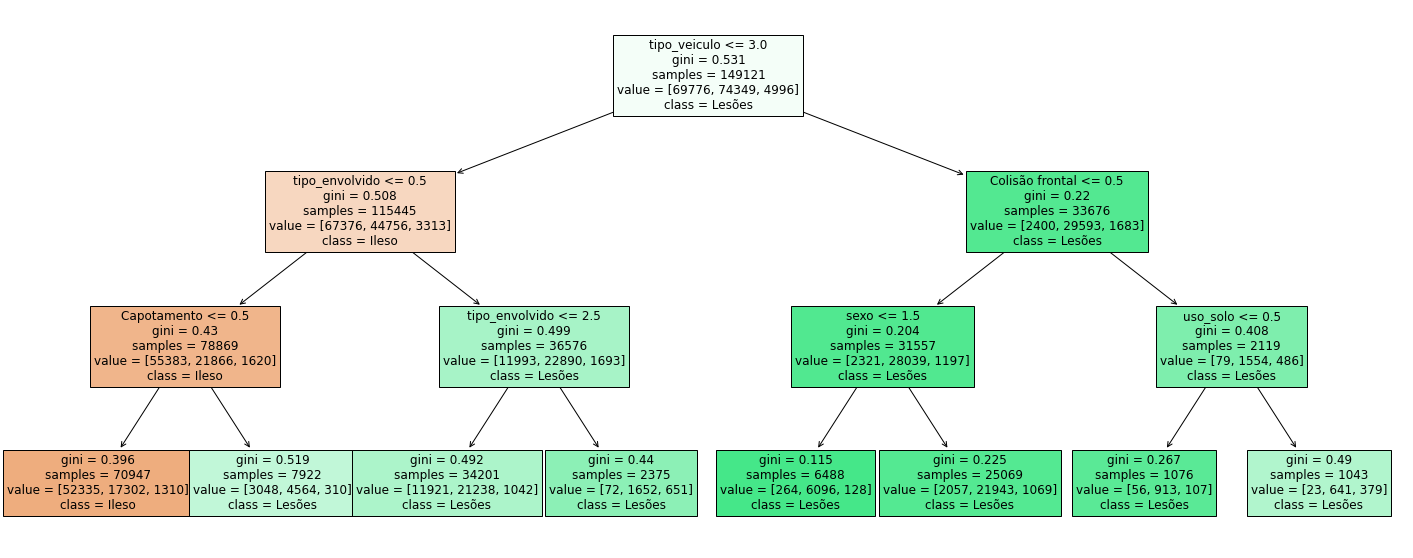

In [ ]:
clf = DecisionTreeClassifier(max_depth=3).fit(df.iloc[:149121,:-1], df['estado_fisico_target'])

plt.figure(figsize=(25,10))
plot_tree(clf, filled=True, fontsize=12, feature_names=df.iloc[:149121,:-1].columns, 
          class_names=target_classes)
plt.show()

In [ ]:

display(df.columns)
display(df.shape)
display(df.dtypes)
display(df['estado_fisico_target'].value_counts())

Index(['feriado', 'dia_semana', 'horario', 'condicao_metereologica',
       'tracado_via', 'tipo_veiculo', 'uso_solo', 'tipo_envolvido', 'idade',
       'sexo', 'latitude', 'longitude', 'eventos_tipo_acidente',
       'Saída de leito carroçável', 'Colisão traseira', 'Colisão frontal',
       'Colisão transversal', 'Atropelamento de Animal', 'Capotamento',
       'Colisão com objeto estático', 'Tombamento',
       'Queda de ocupante de veículo', 'Atropelamento de Pedestre',
       'Colisão lateral', 'Engavetamento', 'Derramamento de carga',
       'Danos eventuais', 'Incêndio', 'Colisão com objeto em movimento',
       'estado_fisico_target'],
      dtype='object')

(149121, 30)

feriado                              int64
dia_semana                           int64
horario                              int64
condicao_metereologica               int64
tracado_via                          int64
tipo_veiculo                         int64
uso_solo                             int64
tipo_envolvido                       int64
idade                              float64
sexo                                 int64
latitude                           float64
longitude                          float64
eventos_tipo_acidente                int64
Saída de leito carroçável            int64
Colisão traseira                     int64
Colisão frontal                      int64
Colisão transversal                  int64
Atropelamento de Animal              int64
Capotamento                          int64
Colisão com objeto estático          int64
Tombamento                           int64
Queda de ocupante de veículo         int64
Atropelamento de Pedestre            int64
Colisão lat

1    74349
0    69776
2     4996
Name: estado_fisico_target, dtype: int64

In [ ]:
## atribuindo os valores das variáveis independentes a 'X' e da variável dependente a 'y'
X = df.iloc[:149121,:-1]
y = df['estado_fisico_target']

display(X.shape)
display(y.shape)

(149121, 29)

(149121,)

In [ ]:
# Separando em variáveis de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

display(np.bincount(y_train))
display(np.bincount(y_test))

# instanciar modelo de regressão logística
reg_log = LogisticRegression(max_iter=100000, solver='lbfgs', multi_class='auto', random_state=42) 

# treinar modelo
classificador = reg_log.fit(X_train, y_train)

display('Train Score: ', reg_log.score(X_train, y_train))
display('Test Score: ', reg_log.score(X_test, y_test))

# Faça a predição nos dados de teste
predicted = classificador.predict(X_test)
# Mostra a acurácia do modelo nos dados de teste 
display(classificador.score(X_test,y_test))

# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
from sklearn.metrics import f1_score
display('F1 Score: ', f1_score(y_test, predicted, average='weighted'))

# Random Forest

from sklearn.ensemble import RandomForestClassifier
rf_class = RandomForestClassifier(n_estimators=120, max_depth=6, random_state=100).fit(X_train, np.ravel(y_train))
display('RandomForest: ', rf_class.score(X_test, y_test))


# Árvore de decisão
clf = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
clf.score(X_test, y_test)
display('DecisionTree: ',clf.score(X_test, y_test))

array([55820, 59479,  3997])

array([13956, 14870,   999])

'Train Score: '

0.7414582215665236

'Test Score: '

0.7414585079631182

0.7414585079631182

'F1 Score: '

0.7293184348583854

'RandomForest: '

0.739815590947192

'DecisionTree: '

0.7372003352891869

In [ ]:
# Knn - loop
k_range = range(1, 25)

scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

print(scores)

[0.6759765297569154, 0.6825817267393126, 0.7009220452640402, 0.7052472757753563, 0.7088683989941325, 0.7089019279128248, 0.710176026823135, 0.7094383906119027, 0.7091701592623638, 0.7110142497904443, 0.7120201173512154, 0.7100754400670578, 0.7121207041072926, 0.7102430846605197, 0.7122548197820621, 0.709002514668902, 0.7092372170997485, 0.7080301760268232, 0.7090360435875943, 0.708197820620285, 0.7074266554903604, 0.7055155071248952, 0.7048449287510478, 0.7040402347024308]


Matriz de confusão
[[10901  3055     0]
 [ 3660 11203     7]
 [  229   760    10]]


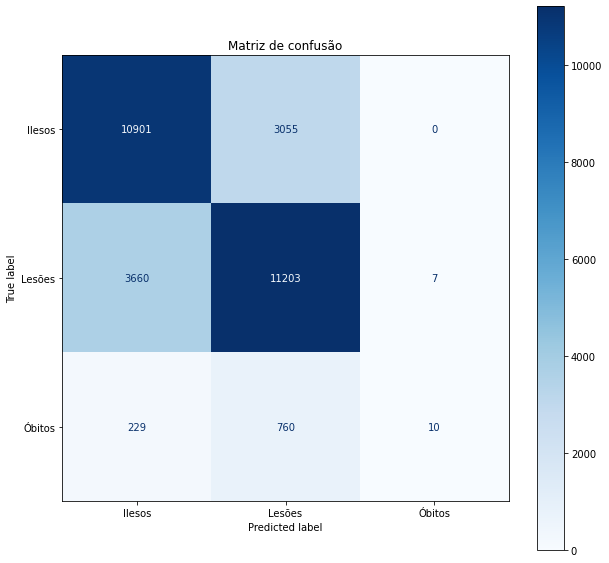

In [ ]:
target_classes = ["Ilesos", "Lesões", "Óbitos"]
title = 'Matriz de confusão'
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(reg_log, X_test, y_test,
                              display_labels=target_classes,
                              cmap=plt.cm.Blues,values_format='',
                              normalize=None, ax=ax)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [ ]:
df['estado_fisico_target'].value_counts()

1    74349
0    69776
2     4996
Name: estado_fisico_target, dtype: int64

Random under-sampling:
2    4996
1    4996
0    4996
Name: estado_fisico_target, dtype: int64


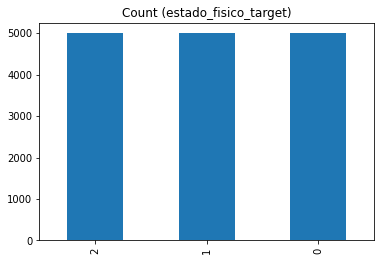

In [ ]:
# Balanceando

# CONTAR CLASSES
count_class_0, count_class_1, count_class_2 = df.estado_fisico_target.value_counts()
# Dividindo por classes
df_class_0 = df[df['estado_fisico_target'] == 0]
df_class_1 = df[df['estado_fisico_target'] == 1]
df_class_2 = df[df['estado_fisico_target'] == 2]
df_class_0_under = df_class_0.sample(count_class_2)
df_class_1_under = df_class_1.sample(count_class_2)
df_test_under = pd.concat([df_class_0_under, df_class_1_under, df_class_2], axis=0)
print('Random under-sampling:')
print(df_test_under.estado_fisico_target.value_counts())
df_test_under.estado_fisico_target.value_counts().plot(kind='bar', title='Count (estado_fisico_target)');

In [ ]:
X = df_test_under.iloc[:14988,:-1]
y = df_test_under['estado_fisico_target']

display(X.shape)
display(y.shape)

(14988, 29)

(14988,)

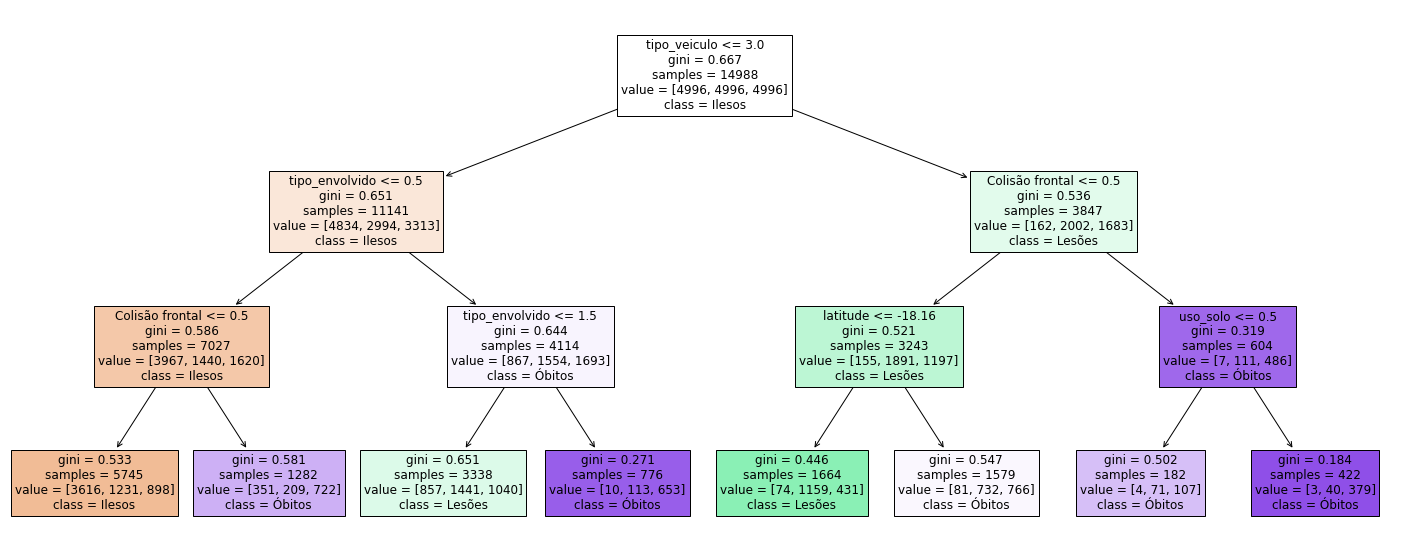

In [ ]:
clf = DecisionTreeClassifier(max_depth=3).fit(df_test_under.iloc[:14988,:-1], df_test_under['estado_fisico_target'])

plt.figure(figsize=(25,10))
plot_tree(clf, filled=True, fontsize=12, feature_names=df_test_under.iloc[:14988,:-1].columns, 
          class_names=target_classes)
plt.show()

In [ ]:
# Separando em variáveis de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

display(np.bincount(y_train))
display(np.bincount(y_test))

# instanciar modelo de regressão logística
reg_log = LogisticRegression(max_iter=100000, solver='lbfgs', multi_class='auto', random_state=42) 

# treinar modelo
classificador = reg_log.fit(X_train, y_train)

display('Train Score: ', reg_log.score(X_train, y_train))
display('Test Score: ', reg_log.score(X_test, y_test))

# Faça a predição nos dados de teste
predicted = classificador.predict(X_test)
# Mostra a acurácia do modelo nos dados de teste 
display(classificador.score(X_test,y_test))

# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
from sklearn.metrics import f1_score
display('F1 Score: ', f1_score(y_test, predicted, average='weighted'))

# Random Forest

from sklearn.ensemble import RandomForestClassifier
rf_class = RandomForestClassifier(n_estimators=120, max_depth=6, random_state=100).fit(X_train, np.ravel(y_train))
display('RandomForest: ', rf_class.score(X_test, y_test))

# Árvore de decisão
clf = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
clf.score(X_test, y_test)
display('DecisionTree: ',clf.score(X_test, y_test))

array([3997, 3997, 3996])

array([ 999,  999, 1000])

'Train Score: '

0.6412844036697247

'Test Score: '

0.6400933955970647

0.6400933955970647

'F1 Score: '

0.6379247465965097

'RandomForest: '

0.628418945963976

'DecisionTree: '

0.633422281521014

In [ ]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 13)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

print(scores)

[0.5276851234156104, 0.4983322214809873, 0.5190126751167445, 0.5330220146764509, 0.5190126751167445, 0.5250166777851901, 0.5283522348232155, 0.5296864576384256, 0.5340226817878586, 0.5300200133422281, 0.5263509006004002, 0.5270180120080054]


Matriz de confusão
[[757 155  87]
 [224 551 224]
 [143 246 611]]


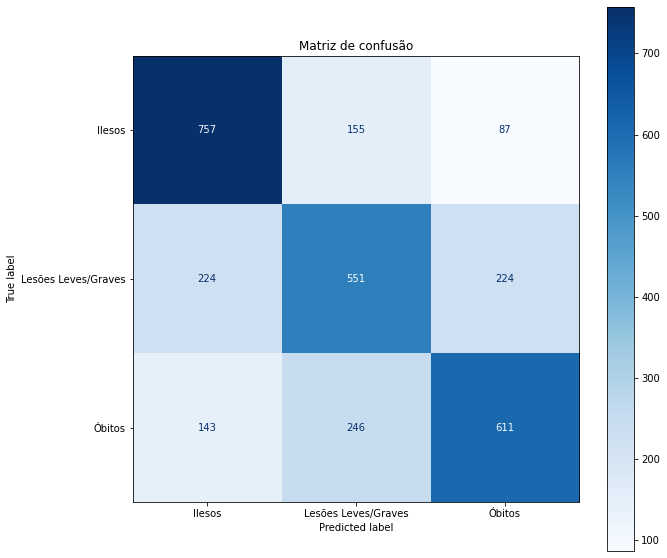

In [ ]:
# Logistic Regression
target_classes = ["Ilesos", "Lesões Leves/Graves", "Óbitos"]
title = 'Matriz de confusão'
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(reg_log, X_test, y_test,
                              display_labels=target_classes,
                              cmap=plt.cm.Blues,values_format='',
                              normalize=None, ax=ax)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [ ]:
# modelo final só com 2 classes no estado_fisico

path_acidentes = '/content/drive/My Drive/acidentes2018_todas_causas_tipos (1).csv'
df = pd.read_csv(path_acidentes, sep=';', na_values='-', decimal=',', engine='python', encoding='ISO-8859-1') 

# Criando colunas com os tipos de acidentes:
df2 = df.drop_duplicates(subset=['tipo_acidente'])

for evento in df2['tipo_acidente'].values:
    df[evento] = 0 

# Atribuindo valor 1 para toda linha em que o tipo de acidente é registrado
m = []
for column in df.columns[-16:]:
    for x in df['tipo_acidente']:
        m.append(x == column)
    df[column] = m
    df[column] = df[column].apply(lambda x: 1 if (x == True) else 0)
    m = []

df = df[~df.estado_fisico.str.contains("Não Informado")] # exclusão de linhas em que o estado físico da vítima não é informado
df['estado_fisico'].replace({"Ileso": 0, "Lesões Leves": 0, "Lesões Graves": 0, "Óbito": 1}, inplace=True)
target_classes = ["Ileso", "Lesões Leves", "Lesões Graves", "Óbito"]


df['feriado'] = df['data_inversa'].apply(lambda x: 0 if (x == '2018-01-01' or x == '2018-02-12' or x == '2018-02-13' or x == '2018-03-30' or x == '2018-04-21' or x == '2018-05-01' or x == '2018-05-31' or 
                                                        x == '2018-09-07' or x == '2018-10-12' or x == '2018-11-02' or x == '2018-11-15' or x == '2018-12-25') else 1) # retornará 1 se feriado e 0 se não for
col = df.pop('feriado')
df.insert(3, col.name, col)

df['horario'] = df['horario'].apply(lambda x: int(str(x)[:-6]))

# Estabelecendo classes de idade:
df['idade'] = df['idade'].astype('Int64')
df['idade'] = df['idade'].fillna(1000) # preenchendo todos os valores NA com 1000
array_ages = []
for x in df['idade']:
    if (x < 10):
        array_ages.append(0)
    elif (10 <= x < 20):
        array_ages.append(1)
    elif (20 <= x < 30):
        array_ages.append(2)
    elif (30 <= x < 40):
        array_ages.append(3)
    elif (40 <= x < 50):
        array_ages.append(4)
    elif (50 <= x < 60):
        array_ages.append(5)
    elif (60 <= x < 70):
        array_ages.append(6)
    elif (70 <= x < 80):
        array_ages.append(7)
    elif (80 <= x <= 122):
        array_ages.append(8)
    else:
        array_ages.append(9)      
df['idade'] = array_ages
df['idade'].replace({9: np.nan}, inplace=True) # todos os valores acima de 122 anos, o que inclui os que eram NA, viram NaN

df['sexo'].replace({"Não Informado": 0, "Ignorado": 0, "Feminino": 1, "Masculino": 2}, inplace=True)

df['tipo_envolvido'].replace({"Condutor": 0, "Passageiro": 1, "Cavaleiro": 2, "Pedestre": 3}, inplace=True)

df['dia_semana'].replace({"segunda-feira": 0, "terça-feira": 1, "quarta-feira": 2, "quinta-feira": 3, "sexta-feira": 4, "sábado": 5, "domingo": 6}, inplace=True)

df['condicao_metereologica'] = df['condicao_metereologica'].replace({'Nublado': 0, 'Céu Claro': 1, 'Chuva': 2, 'Vento': 3, 'Sol': 4, 'Garoa/Chuvisco': 5,
                                                                     'Nevoeiro/Neblina': 6, 'Granizo': 7, 'Ignorado': 8})

df = df[~df.tipo_veiculo.str.contains('Trem-bonde|Chassi-plataforma|Trator misto|Trator de esteira')]
df['tipo_veiculo'].replace({'Automóvel': 2, 'Motocicleta': 5, 'Caminhonete': 2, 'Caminhão-trator': 1, 'Caminhão': 1, 'Ônibus': 1,
                            'Camioneta': 2, 'Motoneta': 5, 'Utilitário': 2, 'Micro-ônibus': 2, 'Semireboque': 1, 'Ciclomotor': 5,
                            'Reboque': 1, 'Triciclo': 5, 'Carroça-charrete': 4, 'Trator de rodas': 1, 'Carro de mão': 6, 'Bicicleta': 5,
                            'Quadriciclo': 5, 'Outros': 0, 'Não Informado': 0}, inplace=True)

df['tracado_via'].replace({ 'Interseção de vias': 0, 'Desvio Temporário': 1, 'Rotatória': 2, 'Retorno Regulamentado': 3, 'Viaduto': 4,
                           'Ponte': 5, 'Túnel': 6, 'Não Informado': 7, 'Curva': 8, 'Reta': 9}, inplace=True)

# Criando coluna eventos_tipo_acidente
df['eventos_tipo_acidente'] = 0

df['uso_solo'] = df['uso_solo'].apply(lambda x: 0 if (x == 'Sim') else 1)

# df['classificacao_acidente'].value_counts()
# Com Vítimas Feridas    228320
# Sem Vítimas             54248
# Com Vítimas Fatais      42178

df.drop(columns=['fase_dia', 'id', 'data_inversa', 'tipo_pista', 'causa_acidente', 'ordem_tipo_acidente', 'tipo_acidente', 'br',
                 'uf', 'km', 'municipio', 'causa_principal', 'classificacao_acidente', 'sentido_via', 'id_veiculo', 'marca',
                 'ano_fabricacao_veiculo', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos', 'regional', 'delegacia', 'uop'], inplace=True)

# Apagando linhas com conteúdo duplicado (linhas idênticas)
df = df.drop_duplicates()

df = df.groupby(['pesid', 'feriado', 'dia_semana', 'horario',
       'condicao_metereologica', 'tracado_via', 'tipo_veiculo', 'uso_solo',
       'tipo_envolvido', 'idade', 'sexo', 'latitude', 'longitude', 'estado_fisico',
        'eventos_tipo_acidente'], as_index=False)[['Saída de leito carroçável',
       'Colisão traseira', 'Colisão frontal', 'Colisão transversal',
       'Atropelamento de Animal', 'Capotamento', 'Colisão com objeto estático',
       'Tombamento', 'Queda de ocupante de veículo',
       'Atropelamento de Pedestre', 'Colisão lateral', 'Engavetamento',
       'Derramamento de carga', 'Danos eventuais', 'Incêndio',
       'Colisão com objeto em movimento' ]].sum()


# Criando coluna_nova e atribuindo valores à coluna_nova
df['eventos_tipo_acidente'] = df[['Saída de leito carroçável', 'Colisão traseira', 'Colisão frontal', 'Colisão transversal',
                        'Atropelamento de Animal', 'Capotamento', 'Colisão com objeto estático', 'Tombamento',
                        'Queda de ocupante de veículo', 'Atropelamento de Pedestre', 'Colisão lateral', 'Engavetamento',
                        'Derramamento de carga', 'Danos eventuais', 'Incêndio', 'Colisão com objeto em movimento' ]].sum(axis=1)


del df['pesid'] # deletando a coluna com o id de acidentados

#Renomeando a coluna target (para a última posição no dframe?):
df['estado_fisico_target'] = df['estado_fisico']
del df['estado_fisico']

df

,feriado,dia_semana,horario,condicao_metereologica,tracado_via,tipo_veiculo,uso_solo,tipo_envolvido,idade,sexo,latitude,longitude,eventos_tipo_acidente,Saída de leito carroçável,Colisão traseira,Colisão frontal,Colisão transversal,Atropelamento de Animal,Capotamento,Colisão com objeto estático,Tombamento,Queda de ocupante de veículo,Atropelamento de Pedestre,Colisão lateral,Engavetamento,Derramamento de carga,Danos eventuais,Incêndio,Colisão com objeto em movimento,estado_fisico_target
0,0,0,0,1,9,5,0,0,2.0,2,-27.599717,-48.575657,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,9,2,0,0,2.0,2,-27.599717,-48.575657,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,9,5,0,1,2.0,1,-27.599717,-48.575657,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,7,2,1,0,6.0,2,-29.728375,-51.633419,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,2,2,8,2,0,0,6.0,2,-26.251443,-48.907259,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149116,1,0,9,4,9,2,0,0,4.0,2,-4.819326,-42.158821,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
149117,0,3,10,0,9,5,1,0,5.0,2,-24.939211,-48.301248,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
149118,1,4,19,1,9,2,0,0,2.0,1,-29.763558,-57.052002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
149119,1,4,19,1,9,5,0,0,2.0,2,-29.763558,-57.052002,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(149121, 30)

Random under-sampling:
1    4996
0    4996
Name: estado_fisico_target, dtype: int64


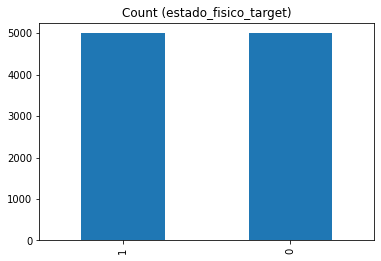

In [ ]:
# Balanceando

# CONTAR CLASSES
count_class_0, count_class_1 = df.estado_fisico_target.value_counts()
# Divide by class
df_class_0 = df[df['estado_fisico_target'] == 0]
df_class_1 = df[df['estado_fisico_target'] == 1]
# df_class_2 = df[df['estado_fisico_target'] == 2]
df_class_0_under = df_class_0.sample(count_class_1)
# df_class_1_under = df_class_1.sample(count_class_2)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
print('Random under-sampling:')
print(df_test_under.estado_fisico_target.value_counts())
df_test_under.estado_fisico_target.value_counts().plot(kind='bar', title='Count (estado_fisico_target)');

In [ ]:
X = df_test_under.iloc[:9992,:-1]
y = df_test_under['estado_fisico_target']

display(X.shape)
display(y.shape)

(9992, 29)

(9992,)

In [ ]:
# Separando em variáveis de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)

display(np.bincount(y_train))
display(np.bincount(y_test))

# instanciar modelo de regressão logística
reg_log = LogisticRegression(max_iter=100000, solver='lbfgs', multi_class='auto', random_state=42) 

# treinar modelo
classificador = reg_log.fit(X_train, y_train)

display('Train Score: ', reg_log.score(X_train, y_train))
display('Test Score: ', reg_log.score(X_test, y_test))

# Faça a predição nos dados de teste
predicted = classificador.predict(X_test)
# Mostra a acurácia do modelo nos dados de teste 
display(classificador.score(X_test,y_test))

# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
from sklearn.metrics import f1_score
display('F1 Score: ', f1_score(y_test, predicted, average='weighted'))

# Random Forest

from sklearn.ensemble import RandomForestClassifier
rf_class = RandomForestClassifier(n_estimators=120, max_depth=6, random_state=100).fit(X_train, np.ravel(y_train))
display('RandomForest: ', rf_class.score(X_test, y_test))

# Árvore de decisão
clf = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
clf.score(X_test, y_test)
display('DecisionTree: ',clf.score(X_test, y_test))

array([3996, 3997])

array([1000,  999])

'Train Score: '

0.7271362442136869

'Test Score: '

0.7248624312156078

0.7248624312156078

'F1 Score: '

0.7248620180953081

'RandomForest: '

0.7328664332166083

'DecisionTree: '

0.711855927963982

In [ ]:
# F1 Score da Random Forest
predicted = rf_class.predict(X_test)

# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
from sklearn.metrics import f1_score
display('F1 Score: ', f1_score(y_test, predicted, average='weighted'))

'F1 Score: '

0.7316875923166364

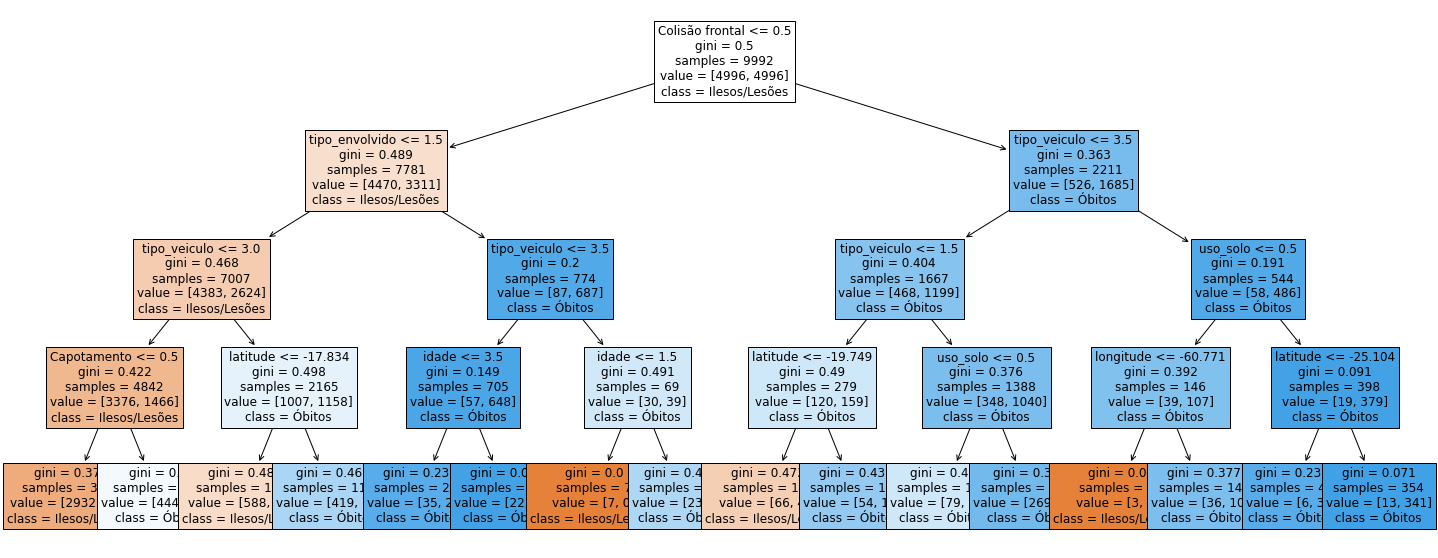

In [ ]:
clf = DecisionTreeClassifier(max_depth=4).fit(df_test_under.iloc[:14976,:-1], df_test_under['estado_fisico_target'])
target_classes = ["Ilesos/Lesões", "Óbitos"]
plt.figure(figsize=(25,10))
plot_tree(clf, filled=True, fontsize=12, feature_names=df_test_under.iloc[:14976,:-1].columns, 
          class_names=target_classes)
plt.show()

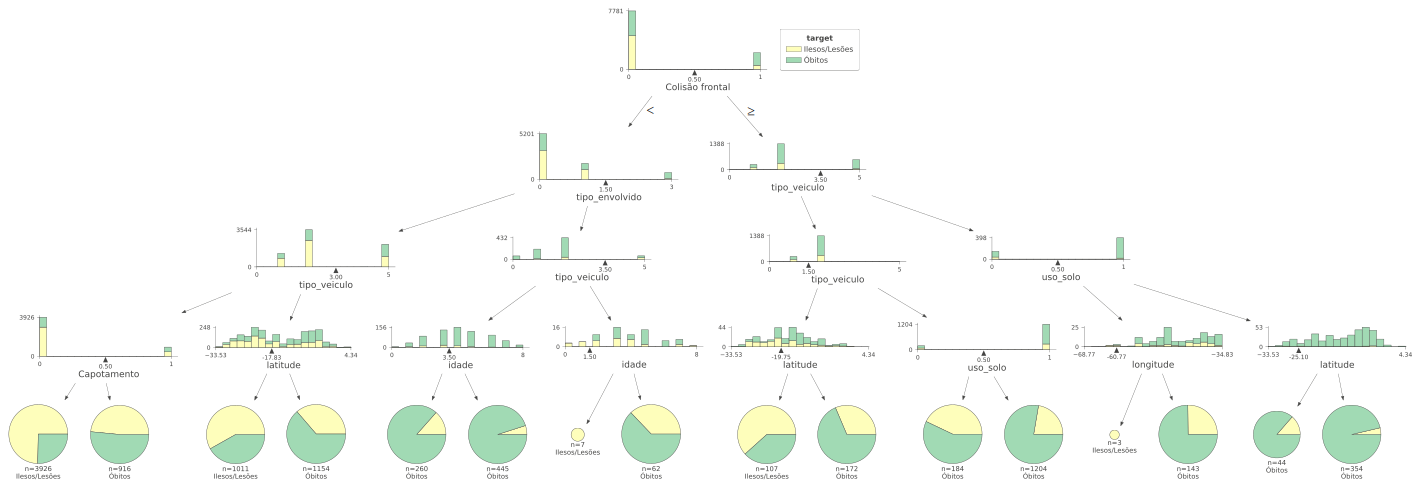

In [ ]:
import sys
!pip install -q dtreeviz
from dtreeviz.trees import * # dtreeviz # remember to load the package

viz = dtreeviz(clf, df_test_under.iloc[:14976,:-1], df_test_under['estado_fisico_target'],
                target_name="target",
                feature_names=df_test_under.iloc[:14976,:-1].columns,
                class_names=list(target_classes))

viz

In [ ]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 25)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

print(scores)

[0.6603301650825413, 0.6348174087043522, 0.6443221610805403, 0.6418209104552276, 0.6438219109554777, 0.6418209104552276, 0.6438219109554777, 0.6413206603301651, 0.6498249124562281, 0.6488244122061031, 0.6518259129564783, 0.6523261630815408, 0.6578289144572286, 0.6568284142071036, 0.6633316658329165, 0.6543271635817909, 0.6633316658329165, 0.6613306653326664, 0.655327663831916, 0.6538269134567284, 0.6533266633316658, 0.6488244122061031, 0.6498249124562281, 0.6413206603301651]


Matriz de confusão
[[726 274]
 [276 723]]


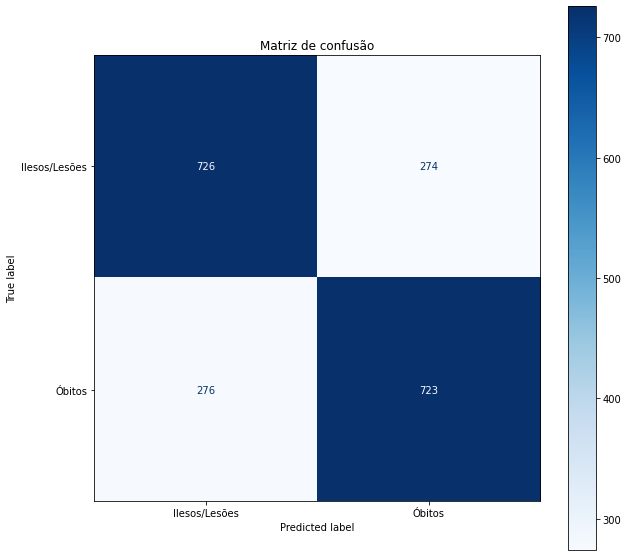

In [ ]:
# Logistic Regression

target_classes = ["Ilesos/Lesões", "Óbitos"]
title = 'Matriz de confusão'
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(reg_log, X_test, y_test,
                              display_labels=target_classes,
                              cmap=plt.cm.Blues,values_format='',
                              normalize=None, ax=ax)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

Matriz de confusão
[[799 201]
 [333 666]]


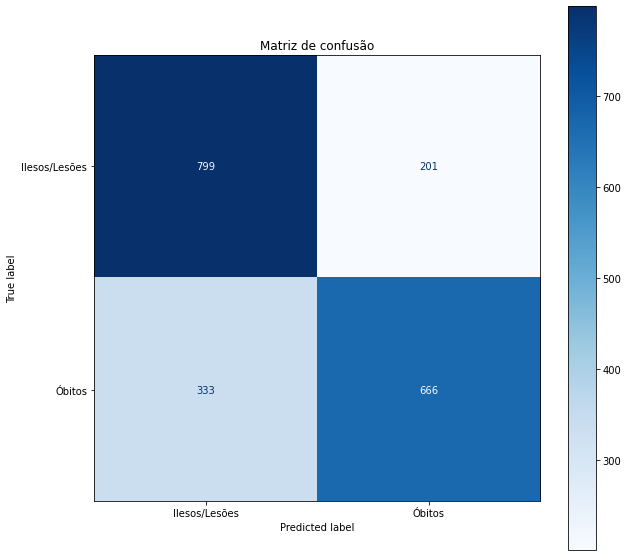

In [ ]:
# Random Forest

target_classes = ["Ilesos/Lesões", "Óbitos"]
title = 'Matriz de confusão'
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(rf_class, X_test, y_test,
                              display_labels=target_classes,
                              cmap=plt.cm.Blues,values_format='',
                              normalize=None, ax=ax)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()


Matriz de confusão
[[727 273]
 [286 713]]


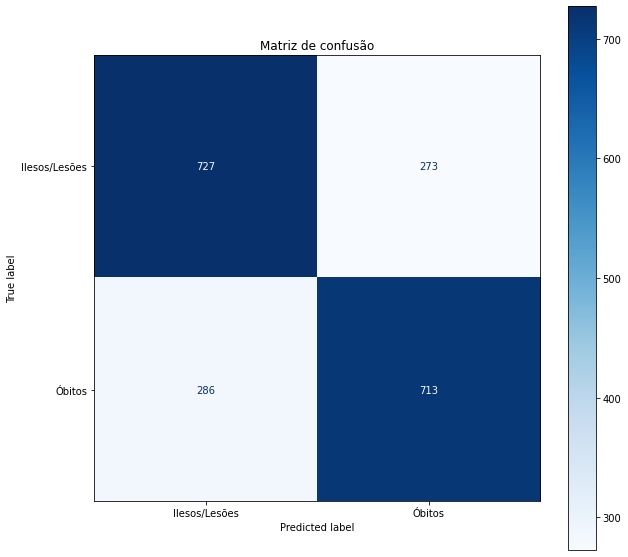

In [ ]:
# Árvore de decisão

target_classes = ["Ilesos/Lesões", "Óbitos"]
title = 'Matriz de confusão'
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(clf, X_test, y_test,
                              display_labels=target_classes,
                              cmap=plt.cm.Blues,values_format='',
                              normalize=None, ax=ax)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()


Matriz de confusão
[[670 330]
 [382 617]]


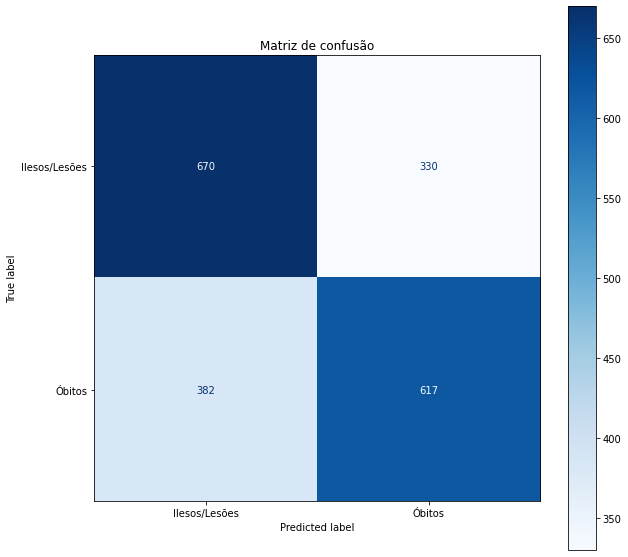

In [ ]:
# KNN 0.6429

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
scores.append(metrics.accuracy_score(y_test, y_pred))

target_classes = ["Ilesos/Lesões", "Óbitos"]
title = 'Matriz de confusão'
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(knn, X_test, y_test,
                              display_labels=target_classes,
                              cmap=plt.cm.Blues,values_format='',
                              normalize=None, ax=ax)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149121 entries, 0 to 149120
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   feriado                          149121 non-null  int64  
 1   dia_semana                       149121 non-null  int64  
 2   horario                          149121 non-null  int64  
 3   condicao_metereologica           149121 non-null  int64  
 4   tracado_via                      149121 non-null  int64  
 5   tipo_veiculo                     149121 non-null  int64  
 6   uso_solo                         149121 non-null  int64  
 7   tipo_envolvido                   149121 non-null  int64  
 8   idade                            149121 non-null  float64
 9   sexo                             149121 non-null  int64  
 10  latitude                         149121 non-null  float64
 11  longitude                        149121 non-null  float64
 12  ev

In [ ]:
from xgboost import XGBClassifier
xgbclass = XGBClassifier(n_estimators=150, max_depth=4)
model_xgboost = xgbclass.fit(X_train, y_train)
model_xgboost.score(X_test, y_test)

0.7648824412206103

Matriz de confusão
[[670 330]
 [382 617]]


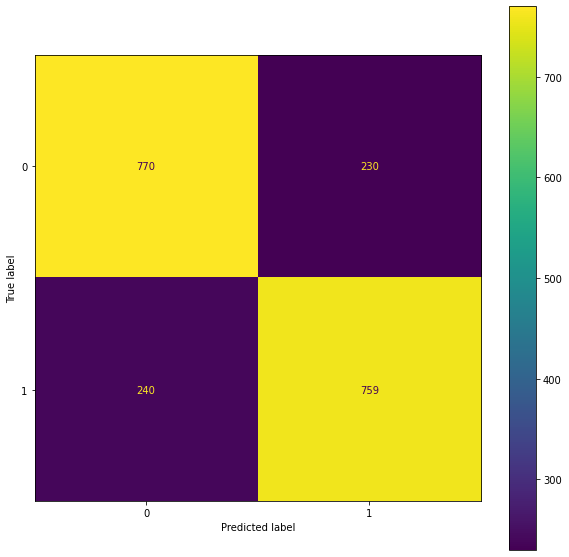

In [ ]:
# modelo XGBClassifier (XGBOOST)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_xgboost, X_test, y_test.values.ravel(), values_format='d', ax=ax);
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)
plt.show()

Matriz de confusão
[[770 230]
 [240 759]]


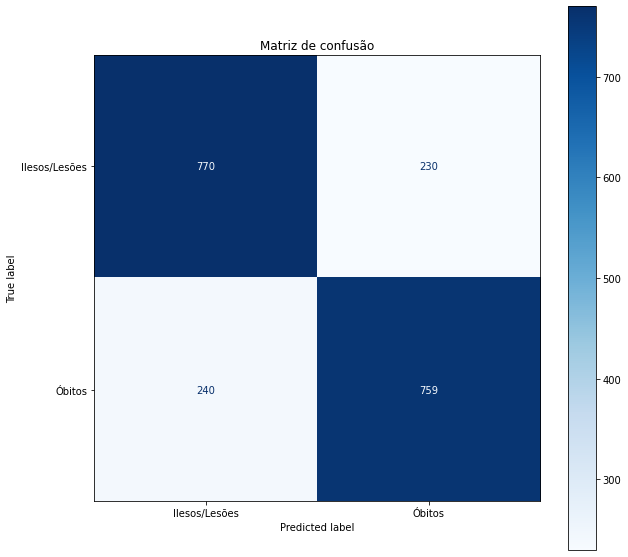

In [ ]:
# modelo XGBClassifier (XGBOOST)

target_classes = ["Ilesos/Lesões", "Óbitos"]
title = 'Matriz de confusão'
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(xgbclass, X_test, y_test,
                              display_labels=target_classes,
                              cmap=plt.cm.Blues,values_format='',
                              normalize=None, ax=ax)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [ ]:
# F1 Score do XGBOOST

model_xgboost = xgbclass.fit(X_train, y_train)

predicted = model_xgboost.predict(X_test)

from sklearn.metrics import f1_score
display('F1 Score: ', f1_score(y_test, predicted, average='weighted'))

'F1 Score: '

0.7648759688211725